In [3]:
### Clean and setup frames ###
# %run study_two_cleaning_old.py
%run study_two_cleaning.py

df_slogans = df_slogans.set_index('slogan', drop=False)
%run set_up_framing.py
set_up_framings(df_slogans, 'slogan')



### Helper functions ### 

def check_assumptions(groups, entire_df):
    # Levene's test for homogenity of variance
    w, p = stats.levene(*groups)
    print("------------------------------------------------------")
    print('Levene\'s test for homogeniety of variance (p > .05 -> variance is equal)')
    print('w =', ('%.2f' % w), 'p =', ('%.4f' % p))
    print("------------------------------------------------------")
    
    # Shapiro-Wilk test for normal distribution
    f, p = stats.shapiro(entire_df)
    print("------------------------------------------------------")
    print('Shapiro-Wilk test for normal distribution (p > .05 -> drawn from normal distribution)')
    print('w =', ('%.2f' % w), 'p =', ('%.4f' % p))
    print("------------------------------------------------------")
    
    
# Calculating effect size 
# taken from https://stackoverflow.com/questions/15436702/estimate-cohens-d-for-effect-size?rq=1
def cohens_d(x, y):
    lx = len(x) - 1
    ly = len(y)- 1
    md = abs(x.mean() - y.mean())        ## mean difference (numerator)
    pld_var = lx * x.var() + ly * y.var()
    pld_var = pld_var/(lx + ly)
    pld_var = np.sqrt(pld_var)
    print('Cohen\'s d:', md/pld_var )
    return cohens_d


def descriptive_stats(groups):
    print("------------------------------------------------------")
    print('Descriptive Stats')
    for k in groups.keys():
        print(k, ':')
        mot_list = np.asarray(groups[k])
        mot_list = mot_list[~np.isnan(mot_list)]
        print('mean =', ('%.2f' % mot_list.mean()) , 'sd =', ('%.2f' % mot_list.std()))
        print('n =', len(mot_list))
    print("------------------------------------------------------")
    
# function for running tukey post hoc tests for all keys in dict for a single motivation
# assumes same format for dict as function run_anova
def run_tukey(df, mot, groups):
    df_no_na = df.dropna(subset=[mot])
    results = pairwise_tukeyhsd(endog=df_no_na[mot],     # Data
                              groups=df_no_na[groups],   # Groups
                              alpha=0.05)          # Significance level
    # convert tukey to df 
    # Taken from https://stackoverflow.com/questions/40516810/saving-statmodels-tukey-hsd-into-a-python-panda-dataframe
    df_tukey = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
    # get only tests where reject is true 
    df_tukey_true = df_tukey[df_tukey['reject'] == True]
    df_tukey = df_tukey.sort_values(by='meandiff')
    print("------------------------------------------------------")
    print('Tukey results where reject is true:')
    display(df_tukey)
    print("------------------------------------------------------")
    
    for index, row in df_tukey.iterrows():
        c_one = df_no_na[df_no_na[groups] == row.group1][mot]
        c_two = df_no_na[df_no_na[groups] == row.group2][mot]
        print(row.group1, row.group2)
        cohens_d(c_one, c_two)  
    
def run_anova_groups(df, mot_ids, grp_id):
    grpd_df = df.groupby(grp_id)
    groups = list(grpd_df.groups.keys())
    measures = []
    for mot in mot_ids:
        print(mot)
        measures = {g:grpd_df.get_group(g)[mot].values for g in groups}
        measures = {g:measures[g][~np.isnan(measures[g])] for g in groups}
        f, p = stats.f_oneway(*measures.values())
        print('F =', ('%.3f' % f), 'p =', ('%.3f' % p))
        if p < .1:
            descriptive_stats(measures)
    
    
def run_just_stats(df, mot_ids, grp_id):
    grpd_df = df.groupby(grp_id)
    groups = list(grpd_df.groups.keys())
    measures = []
    for mot in mot_ids:
        print(mot)
        measures = {g:grpd_df.get_group(g)[mot].values for g in groups}
        measures = {g:measures[g][~np.isnan(measures[g])] for g in groups}
        descriptive_stats(measures)


def run_t_test_groups(df, mot_ids, grp_id):
    t_test_p_vals = [] 
    grpd_df = df.groupby(grp_id)
    groups = list(grpd_df.groups.keys())
    measures = []
    for mot in mot_ids:
        print(mot)
        measures = {g:grpd_df.get_group(g)[mot].values for g in groups}
        measures = {g:measures[g][~np.isnan(measures[g])] for g in groups}
        degrees_of_freedom = (len(measures[groups[0]]) - 1) + (len(measures[groups[1]]) - 1)
        t, p = stats.ttest_ind(*measures.values())
        t_test_p_vals.append(p)
        print('t{', degrees_of_freedom ,'}=', ('%.3f' % t), 'p =', ('%.3f' % p))
        if (p < .1):
            run_tukey(df, mot, grp_id)
            descriptive_stats(measures)
        cohens_d(measures[groups[0]], measures[groups[1]])
    r, p_vals, sidak, bonferroni = multipletests(t_test_p_vals, method='fdr_bh')

    print('Corrected p-values and rejections')
    print('--------------------------------------------------------')
    print('Reject the null? ', r)
    
    print(mot_ids)
    print('Corrected p values: ', p_vals)
    



Number of motivations before taking out people who did not answer at least one: 3055
Number of motivations after taking out people who did not answer at least one: 3002
length of other gender : 71
length of demographics:  2741
gender            float64
age               float64
country            object
participant_id      int64
study_name         object
dtype: object
length of motivations:  3002
science           float64
bored             float64
compare           float64
selfLearn         float64
fun               float64
timestamp           int64
participant_id      int64
study_name         object
dtype: object
length of them together:  2670


/Users/talaugust/Documents/LITW/LITW_Data_Analysis/slogan_testing/slogan_testing_repo/study_two_cleaning.py:186: FutureWarning: 'participant_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [4]:
### Descriptive Stats ###

def describe_participants(df, study):
    df_study = df[df['study'] == study].copy()
    gender = df_study['gender'].dropna()

    print('------------------------------------------------------------------------------' )
    print(study, ' total participants: ', len(df_study))
    print('------------------------------------------------------------------------------' )
    print('------------------------------------------------' )
    print('% of female: ', (100 * (len(gender[gender == 1])/len(gender))))
    print('% of male: ', (100 * (len(gender[gender == 0])/len(gender))))
    print('Average Age: ', df_study['age'].dropna().mean(), '(', ('%.2f' % df_study['age'].dropna().std()) ,')')
    
    
# Get average for motivations
# For all studies combined:
# total_dem_length = len(df_dem_color) + len(df_dem_implicit) + len(df_dem_memory) + len(df_dem_pm) + len(df_dem_thinking_style)
print('------------------------------------------------------------------------------' )
print('ALL STUDIES total participants: ', len(df_mot_dem_data))
print('------------------------------------------------------------------------------' )
print('Descriptive stats - Motivations')
print('------------------------------------------------' )
print('Mean motivations:')
print(df_mot_dem_data[['bored', 'selfLearn', 'fun', 'science', 'compare']].dropna().astype(int).mean())
print('------------------------------------------------' )
print('Std motivations:')
print(df_mot_dem_data[['bored', 'selfLearn', 'fun', 'science', 'compare']].dropna().astype(int).std())

for s in df_mot_dem_data['study'].unique():
    describe_participants(df_mot_dem_data, s)


------------------------------------------------------------------------------
ALL STUDIES total participants:  2670
------------------------------------------------------------------------------
Descriptive stats - Motivations
------------------------------------------------
Mean motivations:
bored        3.251685
selfLearn    4.292135
fun          4.150562
science      3.694382
compare      3.381648
dtype: float64
------------------------------------------------
Std motivations:
bored        1.408222
selfLearn    1.019138
fun          1.026344
science      1.250645
compare      1.369542
dtype: float64
------------------------------------------------------------------------------
color_age  total participants:  785
------------------------------------------------------------------------------
------------------------------------------------
% of female:  49.554140127388536
% of male:  50.445859872611464
Average Age:  26.26624203821656 ( 14.30 )
----------------------------------------

In [5]:
### get count of how many times each slogan was shown, store in df
df_slogans['shown_first'] = 0
df_slogans['shown_second'] = 0
df_slogans['select_first'] = 0
df_slogans['select_second'] = 0
df_slogans['select_total'] = 0

df_clickthrough_setups['participant_id'] = pd.to_numeric(df_clickthrough_setups['participant_id'])
# get count for number of times each slogan appears
for setup in df_setups.iterrows():
    # get prev 1st count for 1st slogan, and 2nd count for 2nd slogan
    prev_count_first = df_slogans.get_value(setup[1]['data']['slogan_1'], 'shown_first')
    prev_count_second = df_slogans.get_value(setup[1]['data']['slogan_2'], 'shown_second')

    # update counts
    df_slogans.set_value(setup[1]['data']['slogan_1'], 'shown_first', prev_count_first + 1) 
    df_slogans.set_value(setup[1]['data']['slogan_2'], 'shown_second', prev_count_second + 1)
    
# get count for number of times each slogan was chosen 
for click in df_clickthrough.iterrows():
    setup = df_clickthrough_setups.loc[click[1]['participant_id'],'data']
    # Check if slogan that was clicked on appeared on top or bottom
    if click[1]['data']['chosen_slogan'] == setup['slogan_1']:
        prev_select_first = df_slogans.get_value(click[1]['data']['chosen_slogan'], 'select_first')
        df_slogans.set_value(click[1]['data']['chosen_slogan'], 'select_first', prev_select_first + 1) 
       
    if click[1]['data']['chosen_slogan'] == setup['slogan_2']: 
        prev_select_second = df_slogans.get_value(click[1]['data']['chosen_slogan'], 'select_second')
        df_slogans.set_value(click[1]['data']['chosen_slogan'], 'select_second', prev_select_second + 1) 
        
    # add to select total seperately in order to check that numbers match 
    prev_select = df_slogans.get_value(click[1]['data']['chosen_slogan'], 'select_total')
    df_slogans.set_value(click[1]['data']['chosen_slogan'], 'select_total', prev_select + 1) 

# Get total number of times a slogan was shown
df_slogans['shown_total'] = df_slogans['shown_first'] + df_slogans['shown_second']

df_slogans['percent_clicked'] = df_slogans['select_total'] / df_slogans['shown_total']



# Reset index of slogans to the slogan itself (making it dict-like) ### 
df_slogans = df_slogans.set_index('slogan', drop=False)

display(df_slogans.groupby('framing')['select_total'].sum())

for study in df_slogans.study.unique():
    display(df_slogans[df_slogans['study'] == study].sort_values(by='percent_clicked'))
   

/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/i

framing
compare_framing       104
fun_bored_framing     167
science_framing       155
self_learn_framing    110
Name: select_total, dtype: int64

,id,slogan,design_id,study,framing,shown_first,shown_second,select_first,select_second,select_total,shown_total,percent_clicked
slogan,,,,,,,,,,,,
What countries see more colorfully?,2,What countries see more colorfully?,2,Color,fun_bored_framing,175,159,17,12,29,334,0.086826
Shine a light on vision research!,6,Shine a light on vision research!,6,Color,science_framing,151,158,11,16,27,309,0.087379
Do you see colors like others?,5,Do you see colors like others?,5,Color,compare_framing,129,132,11,15,26,261,0.099617
Are you a super color perceiver?,1,Are you a super color perceiver?,1,Color,self_learn_framing,157,161,19,15,34,318,0.106918
Help us discover how people see color differently!,4,Help us discover how people see color differently!,4,Color,science_framing,167,150,17,17,35,317,0.110410
Discover the kaleidoscope in your eyes!,3,Discover the kaleidoscope in your eyes!,3,Color,fun_bored_framing,169,153,21,19,40,322,0.124224


,id,slogan,design_id,study,framing,shown_first,shown_second,select_first,select_second,select_total,shown_total,percent_clicked
slogan,,,,,,,,,,,,
Support research on the way we think!,12,Support research on the way we think!,12,Thinking Style,science_framing,137,139,5,3,8,276,0.028986
Compare your thinking style!,11,Compare your thinking style!,11,Thinking Style,compare_framing,132,121,6,6,12,253,0.047431
How do people think differently?,10,How do people think differently?,10,Thinking Style,science_framing,151,133,10,6,16,284,0.056338
Are you more like a scientist or a buddha?,8,Are you more like a scientist or a buddha?,8,Thinking Style,fun_bored_framing,149,132,11,9,20,281,0.071174
How is your brain wired?,9,How is your brain wired?,9,Thinking Style,self_learn_framing,130,158,12,9,21,288,0.072917
Do you think like others?,7,Do you think like others?,7,Thinking Style,compare_framing,152,126,16,16,32,278,0.115108


,id,slogan,design_id,study,framing,shown_first,shown_second,select_first,select_second,select_total,shown_total,percent_clicked
slogan,,,,,,,,,,,,
Can you predict the weather?,13,Can you predict the weather?,13,Implicit Memory,fun_bored_framing,191,195,10,4,16,386,0.041451
Help us build a roadmap of memory!,14,Help us build a roadmap of memory!,14,Implicit Memory,science_framing,227,225,17,15,32,452,0.070796
How does your memory stack up to others?,17,How does your memory stack up to others?,17,Implicit Memory,compare_framing,198,210,18,16,34,408,0.083333
Contribute to our understanding of understanding!,18,Contribute to our understanding of understanding!,18,Implicit Memory,science_framing,182,215,12,25,37,397,0.093199
Test your subconscious!,16,Test your subconscious!,16,Implicit Memory,self_learn_framing,193,220,23,30,55,413,0.133172
Can you decode an alien language?,15,Can you decode an alien language?,15,Implicit Memory,fun_bored_framing,212,215,33,29,62,427,0.145199


In [6]:
### Clickthrough rate and additional formatting for clickthrough dfs ###

# clean clickthroughs to only contain rows that have a corrosponding set up
df_clickthrough = df_clickthrough[df_clickthrough['participant_id'].isin(df_clickthrough_setups['participant_id'])]

# clean clickthroughs of duplicates 
df_clickthrough = df_clickthrough.drop_duplicates('participant_id')

print('rate of clickthrough (selecting either of the two slogans):', 100 * len(df_clickthrough)/len(df_setups))

# Check what percentage of the chosen slogans are the top one (i.e do people just select the top slogan)
count_first_slogans = 0
for click in df_clickthrough.iterrows():
    setup = df_clickthrough_setups.loc[click[1]['participant_id'],'data']    
    if click[1]['data']['chosen_slogan'] == setup['slogan_1']:
        count_first_slogans += 1
        
print(len(df_clickthrough))
print('Percent of first slogans clicked:', ('%.2f' % (100 * df_slogans['select_first'].sum()/(df_slogans['select_total'].sum()))), '%')

print('meam clickthrough percent =', df_slogans['percent_clicked'].mean(), 'sd =', df_slogans['percent_clicked'].std())


rate of clickthrough (selecting either of the two slogans): 17.854763491005997
536
Percent of first slogans clicked: 50.19 %
meam clickthrough percent = 0.08747098025946622 sd = 0.0320883601399868


In [7]:
### Set up DF with all clickthroughs and participant demographics/motivations ###

# Set up framings
for f in df_slogans.framing.unique():
    df_setup_data.loc[df_setup_data['slogan_1'].apply(lambda x: df_slogans.loc[x]['framing'] == f), f] = 1
    df_setup_data.loc[df_setup_data['slogan_2'].apply(lambda x: df_slogans.loc[x]['framing'] == f), f] = 1

df_clickthrough_data['click'] = df_clickthrough_data['chosen_slogan'].apply(lambda x: df_slogans.loc[x]['framing'])

df_clickthrough_data = df_clickthrough_data.rename(index=str, columns={'chosen_slogan':'click_slogan'})
                                                   
df_setup_click_data = df_setup_data.merge(df_clickthrough_data[['participant_id', 'click', 'click_slogan']], on='participant_id', how='left')

df_mot_dem_data['participant_id'] = pd.to_numeric(df_mot_dem_data['participant_id'])
df_setup_click_data['participant_id'] = pd.to_numeric(df_setup_click_data['participant_id'])

df_mot_dem_setup_click_data = df_mot_dem_data.drop('timestamp', axis=1).merge(df_setup_click_data.drop(['data_type','timestamp'], axis=1), on='participant_id', how=
                                                                             'left')

df_mot_dem_setup_click_data = df_mot_dem_setup_click_data.dropna(subset=['gender', 'age', 'bored', 'fun', 'selfLearn', 'science', 'compare'], how='any')



/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 'participant_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


/Users/talaugust/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


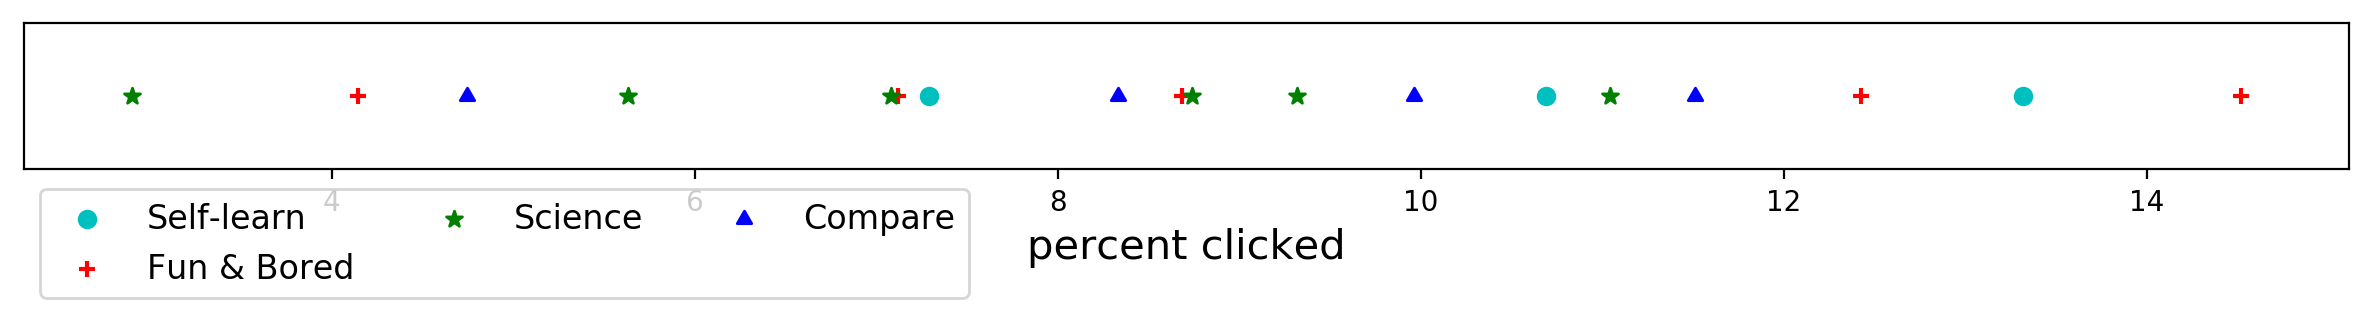

In [8]:

### Make figure 5

import matplotlib.pyplot as plt

grp_frame = df_slogans.groupby('framing')
labels = df_slogans['design_id']
frames = ['Self-learn', 'Fun & Bored', 'Science', 'Compare']
nb_colors = len(plt.rcParams['axes.prop_cycle'])
colors = ['b', 'g', 'r', 'c']
symbols = [(3, 0, 0), '*', '+', (0, 3, 0)]

plt.figure(num=None, figsize=(15, 1), dpi=200)

color_map = {f:colors.pop() for f in df_slogans.framing.unique()}
symbols_map = {f:symbols.pop() for f in df_slogans.framing.unique()}

plots = []

for f in df_slogans.framing.unique(): 
    frame_group = grp_frame.get_group(f)
    y = [1 for f in frame_group['design_id']]
    x = frame_group['percent_clicked'] * 100
    p = plt.scatter(x, y, c=color_map[f], marker=symbols_map[f])
    plots.append(p)
        
plt.legend(plots,
           frames,
           scatterpoints=1,
           loc='lower left',
           bbox_to_anchor=(0,-1),
           ncol=3,
           fontsize=12)
    

plt.axes().get_yaxis().set_ticks([])
plt.margins(0.05)
plt.xlabel('percent clicked', fontsize=15)

# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [9]:
# look at age and motivations across people who clicked through and didn't

dem_and_mot = df_mot_dem_data.columns.drop(['participant_id', 'study', 'timestamp', 'country']).tolist()

print('Click vs No')
print('------------------------------------------------------------')
df_clicked_vs_not = df_mot_dem_setup_click_data.copy()
df_clicked_vs_not['click'] = df_clicked_vs_not['click'].fillna('None')
df_clicked_vs_not.loc[df_clicked_vs_not['click'] != 'None', 'click'] = 'just_click'
dem_and_mot.remove('gender')
run_t_test_groups(df_clicked_vs_not, dem_and_mot, 'click')
print('------------------------------------------------------------')


Click vs No
------------------------------------------------------------
age
t{ 2668 }= -2.594 p = 0.010
------------------------------------------------------
Tukey results where reject is true:


,group1,group2,meandiff,lower,upper,reject
0,None,just_click,1.6238,0.3963,2.8513,True


------------------------------------------------------
None just_click
Cohen's d: 0.13019880455520264
------------------------------------------------------
Descriptive Stats
None :
mean = 25.99 sd = 12.25
n = 2185
just_click :
mean = 27.61 sd = 13.41
n = 485
------------------------------------------------------
Cohen's d: 0.13025057446513308
science
t{ 2668 }= -3.751 p = 0.000
------------------------------------------------------
Tukey results where reject is true:


,group1,group2,meandiff,lower,upper,reject
0,None,just_click,0.2349,0.1121,0.3577,True


------------------------------------------------------
None just_click
Cohen's d: 0.1882676959388517
------------------------------------------------------
Descriptive Stats
None :
mean = 3.65 sd = 1.27
n = 2185
just_click :
mean = 3.89 sd = 1.15
n = 485
------------------------------------------------------
Cohen's d: 0.1883339678726318
bored
t{ 2668 }= 0.252 p = 0.801
Cohen's d: 0.012647120489225568
compare
t{ 2668 }= -2.270 p = 0.023
------------------------------------------------------
Tukey results where reject is true:


,group1,group2,meandiff,lower,upper,reject
0,None,just_click,0.156,0.0213,0.2907,True


------------------------------------------------------
None just_click
Cohen's d: 0.11396625293801674
------------------------------------------------------
Descriptive Stats
None :
mean = 3.35 sd = 1.37
n = 2185
just_click :
mean = 3.51 sd = 1.37
n = 485
------------------------------------------------------
Cohen's d: 0.1140089172208196
selfLearn
t{ 2668 }= -5.112 p = 0.000
------------------------------------------------------
Tukey results where reject is true:


,group1,group2,meandiff,lower,upper,reject
0,None,just_click,0.2603,0.1605,0.3601,True


------------------------------------------------------
None just_click
Cohen's d: 0.25661523013086646
------------------------------------------------------
Descriptive Stats
None :
mean = 4.24 sd = 1.06
n = 2185
just_click :
mean = 4.51 sd = 0.77
n = 485
------------------------------------------------------
Cohen's d: 0.25669537588225766
fun
t{ 2668 }= -3.478 p = 0.001
------------------------------------------------------
Tukey results where reject is true:


,group1,group2,meandiff,lower,upper,reject
0,None,just_click,0.1788,0.078,0.2796,True


------------------------------------------------------
None just_click
Cohen's d: 0.17460126405556453
------------------------------------------------------
Descriptive Stats
None :
mean = 4.12 sd = 1.06
n = 2185
just_click :
mean = 4.30 sd = 0.85
n = 485
------------------------------------------------------
Cohen's d: 0.1746589229902247
Corrected p-values and rejections
--------------------------------------------------------
Reject the null?  [ True  True False  True  True  True]
['age', 'science', 'bored', 'compare', 'selfLearn', 'fun']
Corrected p values:  [1.43132738e-02 5.40196455e-04 8.01162828e-01 2.79096291e-02
 2.04383998e-06 1.02471581e-03]
------------------------------------------------------------


In [10]:
### ANOVA over framings -- did the motivations of participants significantly differ across who clicked on what frame? ### 

dem_and_mot = df_mot_dem_data.columns.drop(['participant_id', 'study', 'timestamp', 'country']).tolist()

print('Descriptive stats of each frames')
print('------------------------------------------------------------')
df_clicked = df_mot_dem_setup_click_data.dropna(subset=['click'], how='any').copy()
print(len(df_clicked))
dem_and_mot.remove('gender')
run_anova_groups(df_clicked, dem_and_mot, 'click')
print('------------------------------------------------------------')
 

Descriptive stats of each frames
------------------------------------------------------------
485
age
F = 1.234 p = 0.297
science
F = 1.600 p = 0.189
bored
F = 2.381 p = 0.069
------------------------------------------------------
Descriptive Stats
compare_framing :
mean = 3.09 sd = 1.35
n = 92
fun_bored_framing :
mean = 3.14 sd = 1.35
n = 154
science_framing :
mean = 3.23 sd = 1.41
n = 147
self_learn_framing :
mean = 3.57 sd = 1.35
n = 92
------------------------------------------------------
compare
F = 1.568 p = 0.196
selfLearn
F = 2.141 p = 0.094
------------------------------------------------------
Descriptive Stats
compare_framing :
mean = 4.58 sd = 0.65
n = 92
fun_bored_framing :
mean = 4.47 sd = 0.77
n = 154
science_framing :
mean = 4.59 sd = 0.78
n = 147
self_learn_framing :
mean = 4.36 sd = 0.83
n = 92
------------------------------------------------------
fun
F = 1.226 p = 0.300
------------------------------------------------------------


In [11]:
## area for checking specific motivations across frames -- looking at the bored motivation since the only one with a close to significant value 
# Now checking if bored does differ significantly across any two groups 
# Run multiple testing correction for all tests 

def run_t_test(values_1, values_2, value_1_name, value_2_name):
    f, p = stats.ttest_ind(values_1,values_2)
    degrees_of_freedom = (len(values_1) - 1) + (len(values_2) - 1)
    effect_size = cohens_d(values_1, values_2)
    print(value_1_name, ':' , values_1.mean(), values_1.std())
    print(value_2_name, ':', values_2.mean(), values_2.std())
    print('$t_{' ,degrees_of_freedom , '} =', ('%.2f' % f), '$', 'p =', '$', ('%.3f' % p), '$','d=', '$', effect_size, '$')
    return p

p_values = []
grpd_df = df_clicked.groupby('click')
values_1 = df_clicked[df_clicked['click'] == 'self_learn_framing'].bored.values
values_2 = df_clicked[df_clicked['click'] == 'compare_framing'].bored.values
p_values.append(run_t_test(values_1, values_2, 'self_learn', 'compare'))


p_vals = []
grpd_df = df_clicked.groupby('click')
values_2 = df_clicked[df_clicked['click'] == 'fun_bored_framing'].bored.values
p_values.append(run_t_test(values_1, values_2, 'self_learn', 'fun_bored'))


p_vals = []
grpd_df = df_clicked.groupby('click')
values_2 = df_clicked[df_clicked['click'] == 'science_framing'].bored.values
p_values.append(run_t_test(values_1, values_2, 'self_learn', 'science'))


multipletests(p_values, method='fdr_bh')

Cohen's d: 0.35396500453712376
self_learn : 3.5652173913043477 1.3537736936469797
compare : 3.0869565217391304 1.3485271668931151
$t_{ 182 } = 2.39 $ p = $ 0.018 $ d= $ <function cohens_d at 0x10b1ade18> $
Cohen's d: 0.3168191047875196
self_learn : 3.5652173913043477 1.3537736936469797
fun_bored : 3.1363636363636362 1.3535340074512485
$t_{ 244 } = 2.39 $ p = $ 0.017 $ d= $ <function cohens_d at 0x10b1ade18> $
Cohen's d: 0.23997094009425177
self_learn : 3.5652173913043477 1.3537736936469797
science : 3.2312925170068025 1.414540752429615
$t_{ 237 } = 1.80 $ p = $ 0.074 $ d= $ <function cohens_d at 0x10b1ade18> $


(array([ True,  True, False]),
 array([0.02697256, 0.02697256, 0.07350487]),
 0.016952427508441503,
 0.016666666666666666)